In [1]:
import glob
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import cv2
import albumentations as A
import matplotlib.pyplot as plt
from PIL import Image
from PIL import ImageDraw
import tqdm
import os

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.3 (you have 1.4.23). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


#### CULane Dataset Lane Points EDA

lane points are must be processed. it should make (B, N, N_p) for all lane points which are padded so that its interval is constant (fixed).

N: number of lanes, (in case of CULane, it must be 4),

N_p: number of points in each lanes (padded to maximum number of points in Lane of CULane dataset)

points are represented as (x, y, c) where x, y are coordinate location and c is binary classes for 0 being background, 1 being foreground.

In [2]:
train_list = '/work/dataset/CULane/list/train_gt.txt'
val_list = '/work/dataset/CULane/list/val_gt.txt'
test_list = '/work/dataset/CULane/list/test.txt'
test_sp = '/work/dataset/CULane/list/test_split/*.txt'

with open(train_list, 'r') as fr:
    train_info = fr.readlines()
train_info = [x.strip() for x in train_info] # remove \n for each rows

with open(val_list, 'r') as fr:
    val_info = fr.readlines()
val_info = [x.strip() for x in val_info]

with open(test_list, 'r') as fr:
    test_info = fr.readlines()
test_info = [x.strip() for x in test_info]

test_sp_list = glob.glob(test_sp)
print(test_sp_list)

['/work/dataset/CULane/list/test_split/test8_night.txt', '/work/dataset/CULane/list/test_split/test1_crowd.txt', '/work/dataset/CULane/list/test_split/test4_noline.txt', '/work/dataset/CULane/list/test_split/test6_curve.txt', '/work/dataset/CULane/list/test_split/test5_arrow.txt', '/work/dataset/CULane/list/test_split/test7_cross.txt', '/work/dataset/CULane/list/test_split/test2_hlight.txt', '/work/dataset/CULane/list/test_split/test0_normal.txt', '/work/dataset/CULane/list/test_split/test3_shadow.txt']


In [3]:
# this function returns lane existance and path information
def extract_info(info_list, base_dir, test_mode=False):
    if not test_mode:
        cls_list = []
        img_list = []
        label_list = []
        for i, info in enumerate(info_list):
            tokens = info.split(' ') # split sentence by ' ' (tokens[0] -> source image location, tokens[1] -> segmentation mask location, tokens[2:] -> lane existance info)
            cls_list.append(' '.join(tokens[2:]))
            img_list.append(base_dir+tokens[0])
            
            path_tokens = tokens[0].split('/')
            label_fname = path_tokens[-1].split('.')[0]+'.lines.txt' # only retrieve filename (before extension .)
            filepath = '/'.join(path_tokens[:-1])
            label_list.append(base_dir+filepath + '/'+label_fname)
        return img_list, label_list, cls_list        
    else:
        img_list = []
        for i, info in enumerate(info_list):
            img_list.append(info)
        return img_list

In [4]:
train_ipath, train_lpath, train_clist = extract_info(train_info, base_dir='/work/dataset/CULane', test_mode=False)
val_ipath, val_lpath, val_clist = extract_info(val_info, base_dir='/work/dataset/CULane', test_mode=False)
test_ipath = extract_info(test_info, base_dir='/work/dataset/CULane', test_mode=True)

print("total number of training images: ", len(train_ipath))
print("total number of training labels: ", len(train_lpath))
print("total number of val images: ", len(val_ipath))
print("total number of val labels: ", len(val_lpath))
print("total number of test images: ", len(test_ipath))

total number of training images:  88880
total number of training labels:  88880
total number of val images:  9675
total number of val labels:  9675
total number of test images:  34680


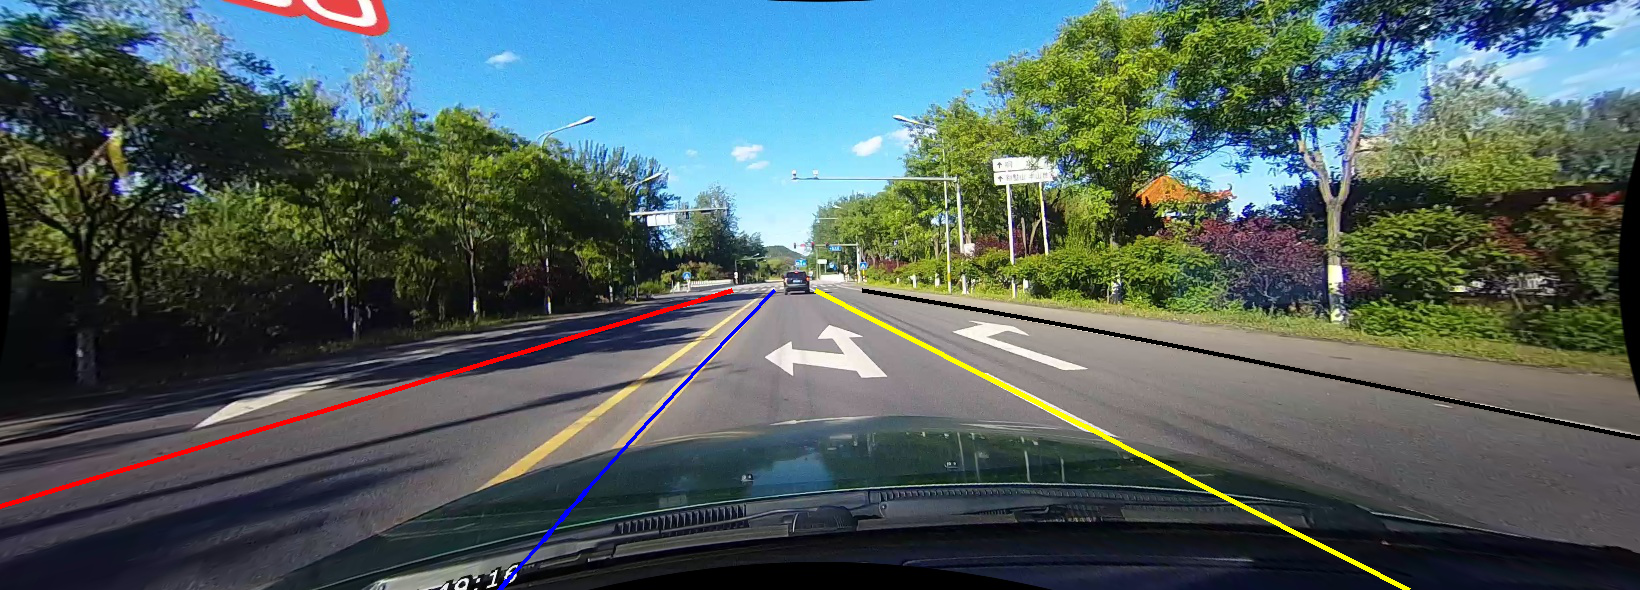

lane labels:  1 1 1 1


In [5]:
ex_path = train_ipath[0]
ex_img = Image.open(ex_path)

ex_label = train_lpath[0]
with open(ex_label, 'r') as fr:
    points = fr.readlines()

points = [p.strip() for p in points]

def draw_lanes(image, labels):
    color_list = ['red', 'blue', 'yellow', 'black']
    draw = ImageDraw.Draw(image)
    lines = []
    for p_set in labels:
        points = []
        tokens = p_set.split(' ')
        for token in tokens:
            points.append(float(token))
        lines.append(points)
    
    lines_p = []
    for line in lines:
        t = []
        for i in range(0, len(line), 2):
            t.append((line[i], line[i+1])) # pair x, y point locations
        lines_p.append(t)
    
    for lane_index, line in enumerate(lines_p, 0):
        for i in range(len(line)-1):
            draw.line((line[i][0], line[i][1], line[i+1][0], line[i+1][1]), fill=color_list[lane_index], width=5)
    
    return image

labeled_img = draw_lanes(ex_img, points)
labeled_img.show()

print("lane labels: ", train_clist[0])

In [6]:
num_of_points = []
for lane in points:
    tokens = lane.split(' ')
    num_of_points.append(len(tokens)/2)

for i, lane in enumerate(num_of_points, 0):
    print(f"number of points in {i}th lane: ", num_of_points[i])
    
points

number of points in 0th lane:  23.0
number of points in 1th lane:  31.0
number of points in 2th lane:  31.0
number of points in 3th lane:  16.0


['-14.0619 510 20.1439 500 53.7171 490 87.2903 480 121.823 470 155.396 460 189.928 450 223.501 440 257.075 430 291.607 420 325.18 410 359.713 400 393.189 390 426.763 380 461.295 370 494.868 360 529.401 350 562.974 340 596.547 330 631.079 320 664.652 310 699.185 300 732.758 290',
 '499.186 590 507.726 580 516.924 570 525.469 560 534.02 550 543.236 540 551.803 530 560.38 520 568.969 510 578.235 500 586.854 490 595.489 480 604.809 470 613.484 460 622.851 450 631.574 440 640.995 430 649.771 420 659.253 410 668.771 400 677.643 390 687.234 380 696.866 370 706.541 360 716.26 350 725.569 340 735.363 330 745.184 320 755.026 310 764.884 300 774.75 290',
 '1409.63 590 1389.99 580 1370.34 570 1350.7 560 1330.17 550 1310.52 540 1290.88 530 1271.24 520 1251.6 510 1231.06 500 1211.42 490 1191.78 480 1172.13 470 1152.49 460 1131.95 450 1112.31 440 1093.06 430 1072.53 420 1052.88 410 1033.24 400 1013.6 390 993.955 380 973.42 370 953.778 360 934.135 350 914.492 340 894.85 330 874.315 320 854.672 310 835

In [7]:
# let's check if the number of lanes does not exceed 4
# let's check if the y coordinate interval is always 10
for lpath in tqdm.tqdm(train_lpath):
    with open(lpath, 'r') as fr:
        label = fr.readlines()
    label = [s.strip() for s in label]
    
    if len(label) > 4:
        print("number of lanes cannot be bigger than 4!")
        print("path: ", lpath)
        print()
    
    maximum = -1
    
    flag = False
    for lane in label:
        tokens = lane.split(' ')
        if len(tokens)/2 > maximum:
            maximum = len(tokens)/2
        for i in range(1, len(tokens), 2):
            c_y = tokens[i]
            if i!=1:
                if int(old_y)-int(c_y) != 10:
                    print("points are not sampled at y coordinate interval 10!") 
                    flag = True
            old_y = c_y
    if flag:
        print("interval of y coordinates are not 10!")
        print("path: ", lpath)
        print()

print("maximum number of points: ", maximum) # maximum 31 points exists

  0%|          | 0/88880 [00:00<?, ?it/s]

  3%|▎         | 3069/88880 [00:09<04:26, 321.48it/s]


KeyboardInterrupt: 

#### Points
1. y-coordinates are sampled at regular intervals 10.
2. many x-coordinates are in float value. they must be converted to int value to be compatible with pixel representation
3. number of points in lane is different with each other. values are must be padded considering y-coordinates
4. points are ordered as decreasing y coordinate order (down-to-up direction as top left corner of images are (0,0))
5. maximum number of points are 31

In [8]:
def preprocess_labels(outdir, label_plist):
    # check if the output directory exists
    if not os.path.exists(outdir):
        print("Creating output directory... ", outdir)
        os.makedirs(outdir)
    
    # read txt label file from label list
    for i, lpath in enumerate(label_plist, 0):
        with open(lpath, 'r') as fr:
            label = fr.readlines()
        label = [s.strip() for s in label]
    
    line_x = []
    line_y = []
    for lane in label:
        x_p = []
        y_p = []
        tokens = lane.split(' ')
        for i in range(0, len(tokens), 2):
            x_p.append(int(tokens[i]))
            y_p.append(int(tokens[i+1]))
        
        # preprocess points to fit the model
        


-5